In [ ]:
from datetime import datetime
import pandas as pd
import os
def parse_file_content(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()

    data = []
    current_timestamp = None
    current_service = None
    current_ping_times = []

    for line in lines:
        if line.startswith("Timestamp:"):
            if current_timestamp and current_service and current_ping_times:
                avg_ping_time = sum(current_ping_times) / len(current_ping_times)
                data.append((current_timestamp, current_service, avg_ping_time))
            parts = line.split(",")
            current_timestamp = parts[0].split("Timestamp: ")[1].strip()
            current_service = parts[1].split("Service: ")[1].strip()
            current_ping_times = []
        elif line.startswith("64 bytes from"):
            ping_time = float(line.split("time=")[1].split(" ms")[0])
            current_ping_times.append(ping_time)

    if current_timestamp and current_service and current_ping_times:
        avg_ping_time = sum(current_ping_times) / len(current_ping_times)
        data.append((current_timestamp, current_service, avg_ping_time))

    return data

def process_files(file_paths):
    all_data = []

    for file_path in file_paths:
        parsed_data = parse_file_content(file_path)
        all_data.extend(parsed_data)

    return all_data
def save_service_data(grouped_data, base_path="./"):
    if not os.path.exists(base_path):
        os.makedirs(base_path)

    files = {}
    for index, row in grouped_data.iterrows():
        service = row['service']
        interval_start = row['interval'].strftime('%Y-%m-%d %H:%M:%S')
        avg_ping = row['avg_ping']
        file_name = f"{service}_{row['interval'].date()}.txt"
        file_path = f"{base_path}/{file_name}"

        if service not in files:
            files[service] = open(file_path, 'w')

        files[service].write(f"{service}{interval_start}, {avg_ping:.2f} ms\n")

    for file in files.values():
        file.close()

    return list(files.keys())


file_paths = ['pingdata.txt']

all_data = process_files(file_paths)


df_parsed = pd.DataFrame(all_data, columns=['timestamp', 'service', 'avg_ping'])


df_parsed['timestamp'] = pd.to_datetime(df_parsed['timestamp'])
df_parsed['interval'] = df_parsed['timestamp'].dt.floor('T')
grouped_data = df_parsed.groupby(['service', 'interval']).agg({'avg_ping': 'mean'}).reset_index()


saved_files = save_service_data(grouped_data)

print("Data saved for services:", saved_files)


Data saved for services: ['IXL', 'Khan Academy', 'Masterclass', 'YouTube']


In [ ]:
import numpy as np
from collections import defaultdict
import random
import matplotlib.pyplot as plt

class MarkovChainForecaster:
    def __init__(self, order):
        self.transition_matrices = {}
        self.max_order = order
        self.states = []

    def ping_time_to_state(self, ping_time):
        if ping_time <= 10: return 0
        elif ping_time <= 15: return 1
        elif ping_time <= 20: return 2
        elif ping_time <= 25: return 3
        elif ping_time <= 30: return 4
        elif ping_time <= 40: return 5
        elif ping_time <= 50: return 6
        elif ping_time <= 60: return 7
        elif ping_time <= 70: return 8
        elif ping_time <= 80: return 9
        elif ping_time <= 90: return 10
        elif ping_time <= 100: return 11
        else: return 12

    def load_data_and_convert_states(self, file_path, service_name):
        states = []
        with open(file_path, 'r') as file:
            for line in file:
                if service_name in line:
                    parts = line.strip().split(',')
                    if len(parts) >= 2:
                        try:
                            ping_time = float(parts[1].strip().split()[0])
                            state = self.ping_time_to_state(ping_time)
                            states.append(state)
                        except ValueError:
                            continue
        self.states = states
        return states

    def load_data_convert_states(self, file_path, service_name):
        states = []
        with open(file_path, 'r') as file:
            for line in file:
                if service_name in line:
                    parts = line.strip().split(',')
                    if len(parts) >= 2:
                        try:
                            ping_time = float(parts[1].strip().split()[0])
                            state = self.ping_time_to_state(ping_time)
                            states.append(state)
                        except ValueError:
                            continue
        return states

    def calculate_transition_matrix(self, states):
        transition_matrix = {}
        for n in range(1, self.max_order + 1):
            for i in range(len(states) - n):
                prev_states_tuple = tuple(states[i:i+n])
                next_state = states[i+n]
                if prev_states_tuple not in transition_matrix:
                    transition_matrix[prev_states_tuple] = defaultdict(int)
                transition_matrix[prev_states_tuple][next_state] += 1

        for prev_states, next_states_counts in transition_matrix.items():
            total = sum(next_states_counts.values())
            probabilities = {state: count / total for state, count in next_states_counts.items()}
            transition_matrix[prev_states] = probabilities
        return transition_matrix

    def prepare_transition_matrices(self, file_paths):
        for service_name, file_path in file_paths.items():
            states = self.load_data_and_convert_states(file_path, service_name)
            self.transition_matrices[service_name] = self.calculate_transition_matrix(states)

    def forecast_next_states(self, service_name, initial_sequence, forecast_length):
        if service_name not in self.transition_matrices:
            print(f"Transition matrix for {service_name} not found.")
            return []

        transition_matrix = self.transition_matrices[service_name]
        forecasts = []
        for _ in range(forecast_length):
            for n in range(self.max_order, 0, -1):
                current_sequence = tuple(initial_sequence[-n:])
                next_state, selected_prob = self.stochastic_next_state(transition_matrix, current_sequence)
                if next_state is not None:
                    forecasts.append((next_state, selected_prob))
                    initial_sequence.append(next_state)
                    break
            else:
                print(f"No transition found for any order starting with sequence {initial_sequence[-self.max_order:]}")
                break
        return forecasts

    def stochastic_next_state(self, transition_matrix, current_sequence):
        possible_transitions = transition_matrix.get(current_sequence)
        if possible_transitions:
            next_states = list(possible_transitions.keys())
            probabilities = list(possible_transitions.values())
            next_state = random.choices(next_states, weights=probabilities)[0]
            selected_prob = possible_transitions[next_state]
            return next_state, selected_prob
        return None, None

    def print_forecasted_states(self, forecasts):
      for state, prob in forecasts:
        print(f"Forecasted state for {service_name}: {state} with probability {prob}")

    def plot_forecast(self,initial_states, forecasted_states):
      plt.figure(figsize=(10, 5))
      observed_len = len(initial_states)
      forecasted_len = len(forecasted_states)


      plt.plot(range(observed_len), initial_states, color='blue', label='Observed data')


      forecasted_states_only = [state for state, _ in forecasted_states]
      plt.plot(range(observed_len, observed_len + forecasted_len), forecasted_states_only, color='red', label='Forecasted states')

      plt.xlabel('Time Step')
      plt.ylabel('State')
      plt.title('State Forecast')
      plt.legend()
      plt.show()




In [ ]:
file_paths = ['pingdata.txt']

all_data = process_files(file_paths)


df_parsed = pd.DataFrame(all_data, columns=['timestamp', 'service', 'avg_ping'])


df_parsed['timestamp'] = pd.to_datetime(df_parsed['timestamp'])
df_parsed['interval'] = df_parsed['timestamp'].dt.floor('T')
grouped_data = df_parsed.groupby(['service', 'interval']).agg({'avg_ping': 'mean'}).reset_index()


saved_files = save_service_data(grouped_data)

print("Data saved for services:", saved_files)

Data saved for services: ['IXL', 'Khan Academy', 'Masterclass', 'YouTube']


Initial Sequence Before Plotting: [2, 1, 1, 2, 1, 1, 2, 4, 4, 2, 3, 3, 1, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 4, 3, 2, 2, 2, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 3, 5, 3, 5, 4, 4, 3, 3, 3, 3, 3, 3, 2, 2, 3, 3, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 3, 2, 2, 4, 4, 2, 2, 3, 3, 2, 2, 3, 2, 2, 3, 2, 4, 4, 5, 3, 3, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 2, 2, 2, 3, 2, 2, 2, 2, 3, 2, 2, 1, 2, 2, 3, 3, 2, 2, 1, 2, 5, 4, 3, 2, 2, 2, 3, 4, 2, 3, 3, 2, 2, 2, 2, 4, 2, 2, 3, 2, 3, 2, 3, 3, 2, 2, 2, 4, 3, 2, 3, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 4, 5, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 1, 2, 2, 2, 1, 2, 1, 1, 1, 1, 2, 2, 1, 1, 1, 2, 1, 3, 2, 2, 2, 1, 1, 1, 1, 2, 2, 1, 1,

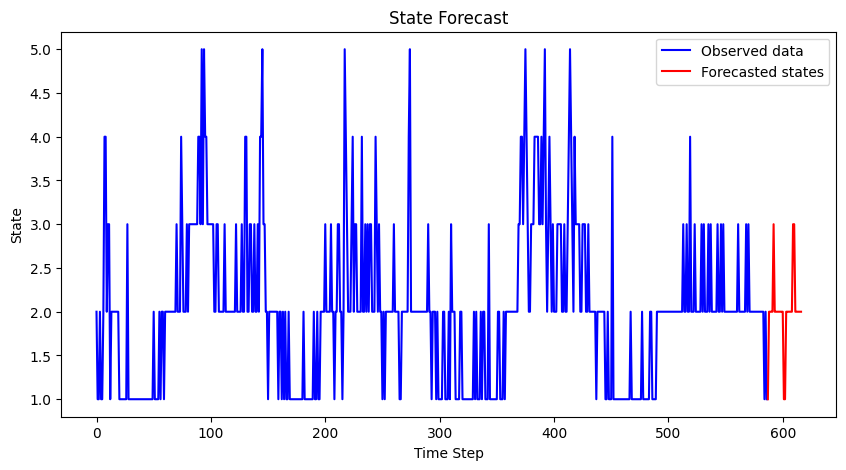

In [ ]:
import copy

file_paths = {
    "Khan Academy": "Khan Academy_2024-03-19.txt",
    "YouTube": "YouTube_2024-03-19.txt",
    "IXL": "IXL_2024-03-19.txt",
    "Masterclass": "Masterclass_2024-03-19.txt"
}

forecaster = MarkovChainForecaster(3)
forecaster.prepare_transition_matrices(file_paths)

service_name = "YouTube"
initial_sequence = forecaster.load_data_convert_states("YouTube_2023-11-29.txt", service_name)

copy_of_init = copy.deepcopy(initial_sequence)

forecast_length = 30
print("Initial Sequence Before Plotting:", initial_sequence)
forecasts = forecaster.forecast_next_states(service_name, initial_sequence, forecast_length)

forecaster.plot_forecast(copy_of_init,forecasts)